In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bisect
from sklearn.preprocessing import *

# dist_measure
# 1 = Euclidean Distance
# 2 = Perpendicular Distance
# 3 = Vertical Distance
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):
        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1
        # Use a single loop to iterate over all the points
        for i in range(1, len(data) - 1):
            left_adj = bisect.bisect_right(pips_x, i) - 1
            right_adj = left_adj + 1
            # Calculate the distance from the point to the line segment
            d = distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure)
            # Update the maximum distance and the insert index
            if d > md:
                md = d
                md_i = i
                insert_index = right_adj
        # Insert the new pip
        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])
    return pips_x, pips_y

# Define a helper function to calculate the distance
def distance(data, pips_x, pips_y, i, left_adj, right_adj, dist_measure):
    time_diff = pips_x[right_adj] - pips_x[left_adj]
    price_diff = pips_y[right_adj] - pips_y[left_adj]
    slope = price_diff / time_diff
    intercept = pips_y[left_adj] - pips_x[left_adj] * slope
    dist_funcs = {
        1: lambda x, y: ( (pips_x[left_adj] - x) ** 2 + (pips_y[left_adj] - y) ** 2 ) ** 0.5 + ( (pips_x[right_adj] - x) ** 2 + (pips_y[right_adj] - y) ** 2 ) ** 0.5, # Euclidean distance
        2: lambda x, y: abs( (slope * x + intercept) - y ) / (slope ** 2 + 1) ** 0.5, # Perpendicular distance
        3: lambda x, y: abs( (slope * x + intercept) - y ) # Vertical distance
    }
    return dist_funcs[dist_measure](i, data[i])

In [209]:

data = pd.read_csv("/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data/GBP_USD_M15_raw_data.csv", parse_dates=['time'])
data = data.set_index('time')

# take data from 2007 to 2014
data = data['2007-01-01':'2008-01-01']

# add new columns from the time column, year, month, day, hour, minute
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data

,open,high,low,close,volume,year,month,day,hour,minute
time,,,,,,,,,,
2007-01-01 21:30:00+00:00,1.95840,1.95860,1.95840,1.95840,18,2007,1,1,21,30
2007-01-01 21:45:00+00:00,1.95840,1.95965,1.95830,1.95920,47,2007,1,1,21,45
2007-01-01 22:00:00+00:00,1.95910,1.96005,1.95890,1.95978,60,2007,1,1,22,0
2007-01-01 22:15:00+00:00,1.96003,1.96190,1.96003,1.96156,91,2007,1,1,22,15
2007-01-01 22:30:00+00:00,1.96138,1.96174,1.96083,1.96174,82,2007,1,1,22,30
...,...,...,...,...,...,...,...,...,...,...
2008-01-01 22:45:00+00:00,1.98707,1.98725,1.98661,1.98670,45,2008,1,1,22,45
2008-01-01 23:00:00+00:00,1.98670,1.98905,1.98670,1.98905,71,2008,1,1,23,0
2008-01-01 23:15:00+00:00,1.98868,1.98965,1.98868,1.98940,90,2008,1,1,23,15


In [286]:
n_close_points = 24
n_perc_points = 4
dist_measure = 1
pips_y_list = []
future_candles = 1
# loop through the data
# start from the 24th point
for index in range(n_close_points, len(data)):
    try:
        x = data['close'].iloc[index-n_close_points:index].to_numpy()
        pips_x, pips_y = find_pips(x, n_perc_points, dist_measure)
        scaled_pips_y = StandardScaler().fit_transform(np.array(pips_y).reshape(-1, 1)).reshape(-1)
        pips_y_dict = {f'pip_{i}': scaled_pips_y[i] for i in range(n_perc_points)}
        j = index - 1
        pips_y_dict['year'] = data['year'].iloc[j]
        pips_y_dict['month'] = data['month'].iloc[j]
        pips_y_dict['day'] = data['day'].iloc[j]
        pips_y_dict['hour'] = data['hour'].iloc[j]
        pips_y_dict['minute'] = data['minute'].iloc[j]
        pips_y_dict['close'] = data['close'].iloc[j]
        pips_y_dict['future_close'] = data['close'].iloc[j+future_candles]
        pips_y_dict['future_return'] = pips_y_dict['future_close'] - pips_y_dict['close']
        pips_y_dict['future_log_ratio'] = 2500 * np.log(pips_y_dict['future_close'] / pips_y_dict['close'])
        pips_y_dict['current_log_ratio'] = 2500 * np.log(pips_y_dict['close'] / data['close'].iloc[j-1])
        pips_y_list.append(pips_y_dict)
    except:
        print('An exception occurred')
        break
    # print(scaled_pips_y)
    # pd.Series(x).plot()
    # for i in range(n_perc_points):
    #     plt.plot(pips_x[i], pips_y[i], marker='o', color='red')
    # plt.plot(pips_x, pips_y, color='black')
    # plt.show()
# pips_y_df = pd.DataFrame(pips_y_list, columns=[f'pip_{i}' for i in range(n_perc_points)])
# pips_y_df_np = pips_y_df.to_numpy()

In [287]:
import pandas as pd
pips_y_df = pd.DataFrame(pips_y_list)
pips_y_df

,pip_0,pip_1,pip_2,pip_3,year,month,day,hour,minute,close,future_close,future_return,future_log_ratio,current_log_ratio
0,-1.669675,0.134062,0.680754,0.854860,2007,1,2,3,15,1.96565,1.96545,-0.00020,-0.254382,-0.127181
1,-1.660483,0.094141,0.723081,0.843261,2007,1,2,3,30,1.96545,1.96562,0.00017,0.216226,-0.254382
2,-1.327838,-0.600032,0.867848,1.060022,2007,1,2,3,45,1.96562,1.96543,-0.00019,-0.241666,0.216226
3,-1.684634,0.652694,0.196948,0.834992,2007,1,2,4,0,1.96543,1.96583,0.00040,0.508743,-0.241666
4,-1.481763,-0.314121,0.682182,1.113702,2007,1,2,4,15,1.96583,1.96561,-0.00022,-0.279796,0.508743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,-1.333016,0.178970,-0.296226,1.450272,2008,1,1,22,15,1.98699,1.98670,-0.00029,-0.364900,0.239066
25343,-0.621309,-1.317175,0.960205,0.978279,2008,1,1,22,45,1.98670,1.98905,0.00235,2.955418,-0.364900
25344,-1.438349,0.018793,0.030357,1.389200,2008,1,1,23,0,1.98905,1.98940,0.00035,0.439870,2.955418
25345,-1.161525,-0.500817,0.117606,1.544736,2008,1,1,23,15,1.98940,1.98876,-0.00064,-0.804392,0.439870


array([[<Axes: title={'center': 'pip_0'}>,
        <Axes: title={'center': 'pip_1'}>,
        <Axes: title={'center': 'pip_2'}>,
        <Axes: title={'center': 'pip_3'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'hour'}>],
       [<Axes: title={'center': 'minute'}>,
        <Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'future_close'}>,
        <Axes: title={'center': 'future_return'}>],
       [<Axes: title={'center': 'future_log_ratio'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

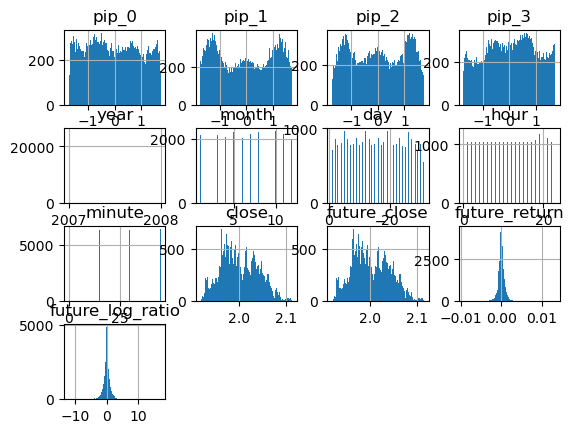

In [273]:
# plot the histogram
pips_y_df.hist(bins=100)

In [ ]:
pips_y_df

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d 
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(5)

# X = pips_y_df_np
X = pips_y_df_np[:700]

estimators = [
    ("k_means_24", KMeans(n_clusters=24)),
    ("k_means_3", KMeans(n_clusters=3)),
    ("k_means_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(13, 10))
titles = ["24 clusters", "3 clusters", "3 clusters, bad init"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("p0")
    ax.set_ylabel("p1")
    ax.set_zlabel("p2")
    ax.set_title(title)

# plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

In [288]:
np.random.seed(5)

pips_y_df_np = pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3']].to_numpy()
est = KMeans(n_clusters=24)
est.fit(pips_y_df_np)
labels = est.labels_

In [289]:
print(len(pips_y_df), len(labels))

25347 25347


In [297]:
# add a new column namely k_label using labels to pips_y_df
pips_y_df['k_label'] = labels
test_pips_y_df = pips_y_df.copy()
# Add two new columns namely k_label_1 and k_label_2 using k_labels of previous two rows of pips_y_df respectively
test_pips_y_df['k_label_1'] = test_pips_y_df['k_label'].shift(1)
# drop the first two rows of pips_y_df
test_pips_y_df = test_pips_y_df.dropna()
test_pips_y_df

,pip_0,pip_1,pip_2,pip_3,year,month,day,hour,minute,close,future_close,future_return,future_log_ratio,current_log_ratio,k_label,k_label_1
1,-1.660483,0.094141,0.723081,0.843261,2007,1,2,3,30,1.96545,1.96562,0.00017,0.216226,-0.254382,7,7.0
2,-1.327838,-0.600032,0.867848,1.060022,2007,1,2,3,45,1.96562,1.96543,-0.00019,-0.241666,0.216226,7,7.0
3,-1.684634,0.652694,0.196948,0.834992,2007,1,2,4,0,1.96543,1.96583,0.00040,0.508743,-0.241666,16,7.0
4,-1.481763,-0.314121,0.682182,1.113702,2007,1,2,4,15,1.96583,1.96561,-0.00022,-0.279796,0.508743,7,16.0
5,-1.489661,-0.316913,0.747373,1.059202,2007,1,2,4,30,1.96561,1.96575,0.00014,0.178055,-0.279796,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,-1.333016,0.178970,-0.296226,1.450272,2008,1,1,22,15,1.98699,1.98670,-0.00029,-0.364900,0.239066,4,4.0
25343,-0.621309,-1.317175,0.960205,0.978279,2008,1,1,22,45,1.98670,1.98905,0.00235,2.955418,-0.364900,14,4.0
25344,-1.438349,0.018793,0.030357,1.389200,2008,1,1,23,0,1.98905,1.98940,0.00035,0.439870,2.955418,4,14.0
25345,-1.161525,-0.500817,0.117606,1.544736,2008,1,1,23,15,1.98940,1.98876,-0.00064,-0.804392,0.439870,4,4.0


RandomForestRegressor


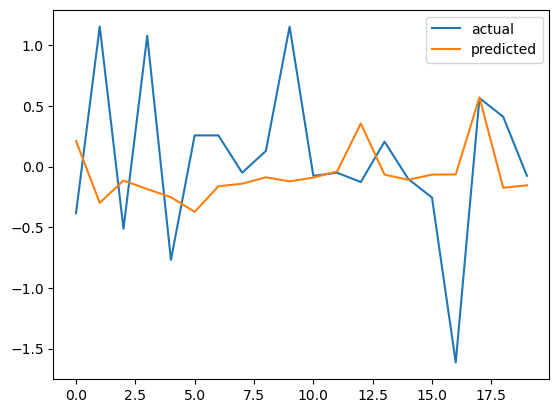

0.49091455110352034
-0.20674981684656313


In [298]:


# create X_train, X_test and y_train, y_test
# take first 100 rows from test_pips_y_df
test_pips_y_df = test_pips_y_df[:200]
X = test_pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3', 'hour', 'minute', 'k_label',  'k_label_1', 'current_log_ratio']].to_numpy()
y = test_pips_y_df['future_log_ratio'].to_numpy()


# X = test_pips_y_df[['pip_0', 'pip_1', 'pip_2', 'pip_3']].to_numpy()
# y = test_pips_y_df['future_return'].to_numpy()

# split the data into train and test
split = 0.9
split_index = int(len(X) * split)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# create a linear regression model
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.ensemble import *

print("RandomForestRegressor")
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# plot the predicted and actual values
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.show()

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)


<Axes: >

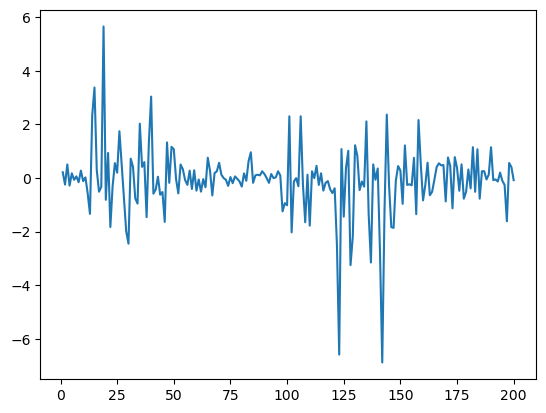

In [294]:
test_pips_y_df['future_log_ratio'].plot()